In [1]:
import pandas as pd                 # pandas is a dataframe library
import matplotlib.pyplot as plt     # matplotlib.pyplot plots data
import numpy as np                  # numpy provides N-dim object support

# do ploting inline instead of in a separate window
%matplotlib inline

In [2]:
#READ AND PARSE AIRLINE FILE
airline_tweets = pd.read_csv('airline_tweets.csv', usecols=['airline_sentiment','tweet_coord'],encoding='utf-8')
airline_tweets=airline_tweets.dropna()
airline_tweets=airline_tweets.loc[airline_tweets['tweet_coord'] != '[0.0, 0.0]']
sentiment_map = { 'negative' : 0,'neutral' :1,'positive' : 2}
airline_tweets['airline_sentiment'] = airline_tweets['airline_sentiment'].map(sentiment_map)
airline_tweets['tweet_coord'].replace(regex=True,inplace=True,to_replace=r'\[',value=r'')
airline_tweets['tweet_coord'].replace(regex=True,inplace=True,to_replace=r'\]',value=r'')
airline_tweets = airline_tweets.reset_index(drop=True)

split_c = airline_tweets['tweet_coord'].apply(lambda x: x.split(','))
airline_tweets['latitude'] = split_c.apply(lambda x: float(x[0]))
airline_tweets['longitude'] = split_c.apply(lambda x: float(x[1]))
airline_tweets.drop(['tweet_coord'],axis=1)

#READ AND PARSE CITIES
cities = pd.read_csv( "cities.csv", delimiter="," ,header='infer',usecols=['name','latitude','longitude'],encoding='utf-8')
cities=cities.dropna()
cities['city_coord']= cities[['latitude','longitude']].values.tolist()

In [3]:
airline_tweets[0:5]

,airline_sentiment,tweet_coord,latitude,longitude
0,2,"40.74804263, -73.99295302",40.748043,-73.992953
1,0,"42.361016, -71.02000488",42.361016,-71.020005
2,1,"33.94540417, -118.4062472",33.945404,-118.406247
3,0,"33.94209449, -118.40410103",33.942094,-118.404101
4,2,"33.2145038, -96.9321504",33.214504,-96.932150


In [4]:
cities[0:5]

,name,latitude,longitude,city_coord
0,les Escaldes,42.50729,1.53414,"[42.507290000000005, 1.53414]"
1,Andorra la Vella,42.50779,1.52109,"[42.50779, 1.52109]"
2,Umm al Qaywayn,25.56473,55.55517,"[25.564729999999997, 55.55517]"
3,Ras al-Khaimah,25.78953,55.94320,"[25.78953, 55.9432]"
4,Khawr Fakkān,25.33132,56.34199,"[25.33132, 56.34199]"


In [5]:
# find the nearest city to the tweet coorinates usin ckdtree(nearest neighbour) and query(Euclidean)
from scipy.spatial import cKDTree

def closest_pts(setA_lat, setA_lng, setB_lat, setB_lng):
    a_x = setA_lat.values
    a_y = setA_lng.values
    b_x = setB_lat.values
    b_y = setB_lng.values
    #print(a_x[0:5])
    a = np.c_[a_x, a_y]
    #print(a)
    b = np.c_[b_x, b_y]
    indx = cKDTree(b).query(a,k=1,p=2)[1]
    #print(indx)
    return pd.Series(b_x[indx]), pd.Series(b_y[indx]),pd.Series(cities['name'][indx])

In [6]:
setA_lat = airline_tweets['latitude']
setA_lng =  airline_tweets['longitude']

setB_lat = cities['latitude']
setB_lng =  cities['longitude']

In [7]:
c_x,c_y,c_n = closest_pts(setA_lat, setA_lng, setB_lat, setB_lng)

In [8]:
c_n = c_n.reset_index(drop=True)
c_n[0:5]

0    New York City
1          Chelsea
2       El Segundo
3       El Segundo
4           Frisco
Name: name, dtype: object

In [9]:
airline_tweets['nearest_latitude'] = c_x
airline_tweets['nearest_longitude'] = c_y
airline_tweets['nearest_city'] =c_n

In [10]:
airline_tweets[0:10]

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
0,2,"40.74804263, -73.99295302",40.748043,-73.992953,40.71427,-74.00597,New York City
1,0,"42.361016, -71.02000488",42.361016,-71.020005,42.39176,-71.03283,Chelsea
2,1,"33.94540417, -118.4062472",33.945404,-118.406247,33.91918,-118.41647,El Segundo
3,0,"33.94209449, -118.40410103",33.942094,-118.404101,33.91918,-118.41647,El Segundo
4,2,"33.2145038, -96.9321504",33.214504,-96.932150,33.15067,-96.82361,Frisco
5,1,"34.0219817, -118.38591198",34.021982,-118.385912,34.02112,-118.39647,Culver City
6,1,"33.57963333, -117.73024772",33.579633,-117.730248,33.56504,-117.72712,Aliso Viejo
7,0,"40.6413712, -73.78311558",40.641371,-73.783116,40.66312,-73.76221,Springfield Gardens
8,2,"36.08457854, -115.13780136",36.084579,-115.137801,36.09719,-115.14666,Paradise
9,1,"37.79374402, -122.39327564",37.793744,-122.393276,37.77493,-122.41942,San Francisco


In [11]:
feature_df = airline_tweets[['nearest_city']]

In [12]:
label_df = airline_tweets['airline_sentiment']

In [35]:
print(type(feature_df))
print(type(label_df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [36]:
# feature encoding
features = pd.get_dummies(feature_df, columns=["nearest_city"])
features[0:5]

,nearest_city_Addison,nearest_city_Aldine,nearest_city_Aliso Viejo,nearest_city_Allen,nearest_city_American Fork,nearest_city_Anaheim,nearest_city_Angeles City,nearest_city_Annapolis,nearest_city_Arbutus,nearest_city_Ashford,...,nearest_city_Whitestone,nearest_city_Williamsport,nearest_city_Willow Grove,nearest_city_Windsor,nearest_city_Winnipeg,nearest_city_Winter Park,nearest_city_Wolverhampton,nearest_city_Woodstock,nearest_city_Xiuying,nearest_city_Zionsville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(label_df.values)
print(list(le.classes_))
labels = le.transform(label_df)
labels[0:5]

[0, 1, 2]


array([2, 0, 1, 0, 2])

In [38]:
label_df.values[0:5]

array([2, 0, 1, 0, 2])

In [39]:
# remove if does not work
#labels = label_df.values has same effect as above transformation

In [40]:
print(features.shape)
print(labels.shape)

(855, 291)
(855,)


In [41]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.40, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [42]:
print(type(X_train),X_train.shape)
print(type(y_train),y_train.shape)
print(type(X_test),X_test.shape)
print(type(y_test),y_test.shape)

<class 'numpy.ndarray'> (513, 291)
<class 'numpy.ndarray'> (513,)
<class 'numpy.ndarray'> (342, 291)
<class 'numpy.ndarray'> (342,)


## FITTING A LOGISTIC REGRESSION

In [217]:
#features.loc[0:,'nearest_city_New York City']

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_model =LogisticRegression()

lr_model.fit(X_train, y_train)
lr_predict_class = lr_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.66


In [219]:
lr_predict_class.max()

0

In [220]:
# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_class)))
print(metrics.confusion_matrix(y_test, lr_predict_class, labels=[0,1,2]) )
#print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_class, labels=[0,1,2]))

Accuracy: 0.6579
[[225   0   0]
 [ 58   0   0]
 [ 59   0   0]]
Classification Report
             precision    recall  f1-score   support

          0       0.66      1.00      0.79       225
          1       0.00      0.00      0.00        58
          2       0.00      0.00      0.00        59

avg / total       0.43      0.66      0.52       342



/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
lr_predict_class[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [48]:
y_test[0:10]

array([0, 1, 0, 0, 2, 0, 1, 2, 2, 2])

In [49]:
#ALL the predictions are 0, that is how accuracy is high

## FITTILG  GaussianNB

In [50]:
from sklearn.naive_bayes import GaussianNB
# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB(priors=None)

In [51]:
# predict values using the training data
nb_predict_class = nb_model.predict(X_test)

# import the performance metrics library
from sklearn import metrics
# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_class)))
print()

Accuracy: 0.3129



In [52]:
nb_predict_class[0:5]

array([1, 1, 1, 0, 2])

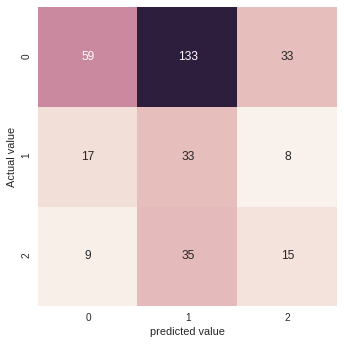

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test,nb_predict_class)
sns.heatmap(mat,square=True,annot=True,fmt='g',cbar=False)
#plt(figsize=(5,5))
plt.xlabel('predicted value')
plt.ylabel('Actual value')

In [54]:
# Although the accuracy is low, this fits the data really well.

In [137]:
from sklearn.model_selection import cross_val_score
cross_val_score(nb_model,X_test, y_test)

array([ 0.32173913,  0.27192982,  0.30973451])

In [222]:
import pickle
# save the classifier
# save the model to disk
filename = 'finalized_model.gnb'
pickle.dump(nb_model, open(filename, 'wb'))   

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
pickle_GNmodel = loaded_model.score(X_test, y_test)
print(pickle_GNmodel)

0.312865497076


In [223]:
loaded_model.predict(X_test)

array([1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1,
       2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 0, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1,
       2, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 1, 1,
       2, 0, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 0, 1,
       1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 0, 2,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2,
       0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0,
       2, 1, 0, 1, 2, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 0, 2, 0, 0, 0, 1, 2, 1,
       0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 0, 1, 2, 1, 1, 0, 2,
       1, 1,

In [194]:
xxx = nb_model.predict_log_proba(X_test)
xxx[0:5]

array([[ -7.94653488e+02,   0.00000000e+00,  -1.38182476e+02],
       [ -7.94653463e+02,   0.00000000e+00,  -1.38182484e+02],
       [ -7.86377004e+02,   0.00000000e+00,  -1.42435122e+02],
       [  0.00000000e+00,  -8.80635026e+09,  -8.80635039e+09],
       [ -6.68972239e+02,  -8.80635104e+09,   0.00000000e+00]])

In [196]:
#nb_model.predict_log_proba? # delete me
nb_model.predict_proba?

In [208]:
# delete
log_probabilities = nb_model.predict_log_proba(X_test)

In [139]:
probabilities = nb_model.predict_proba(X_test)

In [140]:
nb_model.classes_

array([0, 1, 2])

In [210]:
probabilities[0:50]

array([[  0.00000000e+000,   1.00000000e+000,   9.73000713e-061],
       [  0.00000000e+000,   1.00000000e+000,   9.72993290e-061],
       [  0.00000000e+000,   1.00000000e+000,   1.38424357e-062],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  2.94474640e-291,   0.00000000e+000,   1.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000,   1.50909864e-054],
       [  0.00000000e+000,   1.00000000e+000,   9.72993290e-061],
       [  0.00000000e+000,   1.00000000e+000,   9.72993290e-061],
       [  0.00000000e+000,   1.00000000e+000,   1.97720306e-064],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000,   9.72991434e-061],
       [  

In [142]:
probabilities.shape

(342, 3)

In [143]:
#delete me
nb_model.predict_proba?

In [144]:
classes = nb_model.classes_

In [145]:
X_test[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [146]:
predict = nb_model.predict(X_test)

In [147]:
predict[0:5]

array([1, 1, 1, 0, 2])

In [148]:
feature_names=['nearest_city_Addison', 'nearest_city_Aldine',
       'nearest_city_Aliso Viejo', 'nearest_city_Allen',
       'nearest_city_American Fork', 'nearest_city_Anaheim',
       'nearest_city_Angeles City', 'nearest_city_Annapolis',
       'nearest_city_Arbutus', 'nearest_city_Ashford',
       'nearest_city_Ashland', 'nearest_city_Ashtabula',
       'nearest_city_Atascocita', 'nearest_city_Augusta',
       'nearest_city_Aurora', 'nearest_city_Austin',
       'nearest_city_Baltimore', 'nearest_city_Battersea',
       'nearest_city_Bellaire', 'nearest_city_Belvedere Park',
       'nearest_city_Benito Juarez', 'nearest_city_Bensenville',
       'nearest_city_Bergeijk', 'nearest_city_Beverly Hills',
       'nearest_city_Birmingham', 'nearest_city_Boca Raton',
       'nearest_city_Boise', 'nearest_city_Bonita Springs',
       'nearest_city_Boston', 'nearest_city_Boulder', 'nearest_city_Bowie',
       'nearest_city_Bozeman', 'nearest_city_Brentwood',
       'nearest_city_Bridgetown', 'nearest_city_Brighton',
       'nearest_city_Brooklyn', 'nearest_city_Brownsville',
       'nearest_city_Brushy Creek', 'nearest_city_Burbank',
       'nearest_city_Bushwick', 'nearest_city_Calgary',
       'nearest_city_Camberwell', 'nearest_city_Canarsie',
       'nearest_city_Canary Wharf', 'nearest_city_Cancún',
       'nearest_city_Candelaria', 'nearest_city_Carolina',
       'nearest_city_Cartagena', 'nearest_city_Cary',
       'nearest_city_Charlotte', 'nearest_city_Chelsea',
       'nearest_city_Chicago', 'nearest_city_Chillum',
       'nearest_city_Cicero', 'nearest_city_City of Milford (balance)',
       'nearest_city_Cleveland', 'nearest_city_College Point',
       'nearest_city_Commack', 'nearest_city_Commerce City',
       'nearest_city_Conroe', 'nearest_city_Coppell',
       'nearest_city_Coral Gables', 'nearest_city_Corpus Christi',
       'nearest_city_Costa Mesa', 'nearest_city_Cottonwood Heights',
       'nearest_city_Council Bluffs', 'nearest_city_Cranberry Township',
       'nearest_city_Cudahy', 'nearest_city_Culver City',
       'nearest_city_Cypress', 'nearest_city_Dallas',
       'nearest_city_Dania Beach', 'nearest_city_Decatur',
       'nearest_city_Denver', 'nearest_city_Dickson', 'nearest_city_Dover',
       'nearest_city_Drexel Hill', 'nearest_city_Dubai',
       'nearest_city_Durham', 'nearest_city_Dyker Heights',
       'nearest_city_East Lansing', 'nearest_city_East Massapequa',
       'nearest_city_East Point', 'nearest_city_East York',
       'nearest_city_Egypt Lake-Leto', 'nearest_city_El Dorado Hills',
       'nearest_city_El Segundo', 'nearest_city_Elizabeth',
       'nearest_city_Elizabeth City', 'nearest_city_Etobicoke',
       'nearest_city_Euless', 'nearest_city_Evanston',
       'nearest_city_Fairhaven', 'nearest_city_Fairview Park',
       'nearest_city_Farragut', 'nearest_city_Ferndale',
       'nearest_city_Flagami', 'nearest_city_Florence',
       'nearest_city_Forest Hills', 'nearest_city_Four Corners',
       'nearest_city_Franklin Park', 'nearest_city_Friendswood',
       'nearest_city_Frisco', 'nearest_city_Funza', 'nearest_city_Gahanna',
       'nearest_city_Garland', 'nearest_city_Germantown',
       'nearest_city_Gladstone', 'nearest_city_Glen Avon',
       'nearest_city_Glendale', 'nearest_city_Golden',
       'nearest_city_Grapevine', 'nearest_city_Hale',
       'nearest_city_Haltom City', 'nearest_city_Hampton Park',
       'nearest_city_Harlem', 'nearest_city_Harrison',
       'nearest_city_Henderson', 'nearest_city_Herriman',
       'nearest_city_Hilton Head', 'nearest_city_Hoboken',
       'nearest_city_Hollywood', 'nearest_city_Honolulu',
       'nearest_city_Hope Mills', 'nearest_city_Houston',
       'nearest_city_Howard Beach', 'nearest_city_Huntington Beach',
       'nearest_city_Islip', 'nearest_city_Jackson Heights',
       'nearest_city_Jacksonville Beach', 'nearest_city_Jersey City',
       'nearest_city_Johnston', 'nearest_city_Kannapolis',
       'nearest_city_Kenner', 'nearest_city_Kensington',
       'nearest_city_Kent', 'nearest_city_Key West',
       'nearest_city_Kissimmee', 'nearest_city_La Vergne',
       'nearest_city_Lake in the Hills', 'nearest_city_Leawood',
       'nearest_city_Lebanon', 'nearest_city_Levittown',
       'nearest_city_Lexington', 'nearest_city_Liberty',
       'nearest_city_Long Beach', 'nearest_city_Long Island City',
       'nearest_city_Longview', 'nearest_city_Louisville',
       'nearest_city_Lubbock', 'nearest_city_Manhattan',
       'nearest_city_Mariners Harbor', 'nearest_city_Marlborough',
       'nearest_city_Matthews', 'nearest_city_Meadow Woods',
       'nearest_city_Mentor', 'nearest_city_Miami Beach',
       'nearest_city_Midland', 'nearest_city_Millbrae',
       'nearest_city_Milton', 'nearest_city_Minneapolis',
       'nearest_city_Montrose', 'nearest_city_Morristown',
       'nearest_city_Morrisville', 'nearest_city_Mount Vernon',
       'nearest_city_Mountain Brook', 'nearest_city_Napa',
       'nearest_city_Nashville', 'nearest_city_Nassau',
       'nearest_city_New York City', 'nearest_city_Newark',
       'nearest_city_Niles', 'nearest_city_North Atlanta',
       'nearest_city_North Canton', 'nearest_city_North Charleston',
       'nearest_city_North Chicago', 'nearest_city_North Little Rock',
       'nearest_city_North Miami', 'nearest_city_North Salt Lake',
       'nearest_city_Oak Hill', 'nearest_city_Oak Ridge',
       'nearest_city_Oakland', 'nearest_city_Okolona',
       'nearest_city_Orange', 'nearest_city_Orchards',
       'nearest_city_Ossining', 'nearest_city_Overland',
       'nearest_city_Paderborn', 'nearest_city_Palm Desert',
       'nearest_city_Palm Springs', 'nearest_city_Paradise',
       'nearest_city_Parole', 'nearest_city_Parsippany',
       'nearest_city_Philadelphia', 'nearest_city_Phoenix',
       'nearest_city_Phra Pradaeng', 'nearest_city_Plainfield',
       'nearest_city_Pleasantville', 'nearest_city_Polanco',
       'nearest_city_Port Chester', 'nearest_city_Port Richmond',
       'nearest_city_Portland', 'nearest_city_Potomac',
       'nearest_city_Punta Cana', 'nearest_city_Queens Village',
       'nearest_city_Queensbury', 'nearest_city_Rahway',
       'nearest_city_Rancho Cucamonga', 'nearest_city_Rancho Penasquitos',
       'nearest_city_Rexburg', 'nearest_city_Richfield',
       'nearest_city_Rio Rancho', 'nearest_city_Rock Hill',
       'nearest_city_Rockland', 'nearest_city_Rogers',
       'nearest_city_Romulus', 'nearest_city_Ronkonkoma',
       'nearest_city_Roswell', 'nearest_city_Rubidoux',
       'nearest_city_Rutland', 'nearest_city_Råsunda',
       'nearest_city_Salisbury', 'nearest_city_Salt Lake City',
       'nearest_city_San Bruno', 'nearest_city_San Carlos Park',
       'nearest_city_San Diego', 'nearest_city_San Francisco',
       'nearest_city_San Luis Obispo', 'nearest_city_Santa Ana',
       'nearest_city_Santa Clara', 'nearest_city_Santa Monica',
       'nearest_city_Savannah', 'nearest_city_SeaTac',
       'nearest_city_Seattle', 'nearest_city_Secaucus',
       'nearest_city_Security-Widefield', 'nearest_city_Seven Oaks',
       'nearest_city_Shanghai', 'nearest_city_Shrewsbury',
       'nearest_city_Singapore', 'nearest_city_Skokie',
       'nearest_city_Somerset', 'nearest_city_South Jordan',
       'nearest_city_Sparks', 'nearest_city_Spring Valley',
       'nearest_city_Springfield', 'nearest_city_Springfield Gardens',
       'nearest_city_Summerlin South', 'nearest_city_Sydney',
       'nearest_city_Tacoma', 'nearest_city_Tallahassee',
       'nearest_city_Tampa', 'nearest_city_Tempe',
       'nearest_city_Tempe Junction', 'nearest_city_The Valley',
       'nearest_city_Torrance', "nearest_city_Town 'n' Country",
       'nearest_city_Troy', 'nearest_city_Tung Chung',
       'nearest_city_Union', 'nearest_city_Universal City',
       'nearest_city_Upper Saint Clair', 'nearest_city_Vancouver',
       'nearest_city_Venustiano Carranza', 'nearest_city_Wakefield',
       'nearest_city_Waltham', 'nearest_city_Warwick',
       'nearest_city_Washington Heights', 'nearest_city_Washington, D.C.',
       'nearest_city_Waterford', 'nearest_city_Wayne',
       'nearest_city_West Albany', 'nearest_city_West Orange',
       'nearest_city_West Pensacola', 'nearest_city_West Raleigh',
       'nearest_city_West Sacramento', 'nearest_city_West Valley City',
       'nearest_city_Westford', 'nearest_city_Wethersfield',
       'nearest_city_Weymouth', 'nearest_city_White Plains',
       'nearest_city_Whitestone', 'nearest_city_Williamsport',
       'nearest_city_Willow Grove', 'nearest_city_Windsor',
       'nearest_city_Winnipeg', 'nearest_city_Winter Park',
       'nearest_city_Wolverhampton', 'nearest_city_Woodstock',
       'nearest_city_Xiuying', 'nearest_city_Zionsville']

In [149]:
len(feature_names)

291

In [150]:
type(feature_names)

list

In [151]:
type(probabilities)

numpy.ndarray

In [152]:
probabilities.shape

(342, 3)

In [ ]:
# delete me


In [153]:
probabilities_df = pd.DataFrame(probabilities,columns=['negative','neutral','positive'])

In [154]:
probabilities_df[0:5]

,negative,neutral,positive
0,0.000000e+00,1.0,9.730007e-61
1,0.000000e+00,1.0,9.729933e-61
2,0.000000e+00,1.0,1.384244e-62
3,1.000000e+00,0.0,0.000000e+00
4,2.944746e-291,0.0,1.000000e+00


In [155]:
feature_name_series = pd.Series(feature_names)

In [156]:
probabilities_df['cities'] = feature_name_series

In [157]:
probabilities_df[0:5]

,negative,neutral,positive,cities
0,0.000000e+00,1.0,9.730007e-61,nearest_city_Addison
1,0.000000e+00,1.0,9.729933e-61,nearest_city_Aldine
2,0.000000e+00,1.0,1.384244e-62,nearest_city_Aliso Viejo
3,1.000000e+00,0.0,0.000000e+00,nearest_city_Allen
4,2.944746e-291,0.0,1.000000e+00,nearest_city_American Fork


In [158]:
city_probability = probabilities_df[['cities','negative','neutral','positive']]

In [159]:
city_probability[0:5]

,cities,negative,neutral,positive
0,nearest_city_Addison,0.000000e+00,1.0,9.730007e-61
1,nearest_city_Aldine,0.000000e+00,1.0,9.729933e-61
2,nearest_city_Aliso Viejo,0.000000e+00,1.0,1.384244e-62
3,nearest_city_Allen,1.000000e+00,0.0,0.000000e+00
4,nearest_city_American Fork,2.944746e-291,0.0,1.000000e+00


In [160]:
type(predict)

numpy.ndarray

In [161]:
predictions = pd.Series(predict)
predictions[0:5]

0    1
1    1
2    1
3    0
4    2
dtype: int64

In [162]:
city_probability['model_predictions'] = predictions

/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [164]:
city_probability[0:10]

,cities,negative,neutral,positive,model_predictions
0,nearest_city_Addison,0.000000e+00,1.0,9.730007e-61,1
1,nearest_city_Aldine,0.000000e+00,1.0,9.729933e-61,1
2,nearest_city_Aliso Viejo,0.000000e+00,1.0,1.384244e-62,1
3,nearest_city_Allen,1.000000e+00,0.0,0.000000e+00,0
4,nearest_city_American Fork,2.944746e-291,0.0,1.000000e+00,2
5,nearest_city_Anaheim,0.000000e+00,1.0,0.000000e+00,1
6,nearest_city_Angeles City,0.000000e+00,1.0,1.509099e-54,1
7,nearest_city_Annapolis,0.000000e+00,1.0,9.729933e-61,1
8,nearest_city_Arbutus,0.000000e+00,1.0,9.729933e-61,1
9,nearest_city_Ashford,0.000000e+00,1.0,1.977203e-64,1


In [178]:
y_test[0:10]

array([0, 1, 0, 0, 2, 0, 1, 2, 2, 2])

In [180]:
sentiment_map = { 0:'negative',1:'neutral',2:'positive'}
city_probability['sentiment_prediction'] = city_probability['model_predictions'].map(sentiment_map)

/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [185]:
city_probability[0:10]

,cities,negative,neutral,positive,model_predictions,sentiment_prediction
0,nearest_city_Addison,0.000000e+00,1.0,9.730007e-61,1,neutral
1,nearest_city_Aldine,0.000000e+00,1.0,9.729933e-61,1,neutral
2,nearest_city_Aliso Viejo,0.000000e+00,1.0,1.384244e-62,1,neutral
3,nearest_city_Allen,1.000000e+00,0.0,0.000000e+00,0,negative
4,nearest_city_American Fork,2.944746e-291,0.0,1.000000e+00,2,positive
5,nearest_city_Anaheim,0.000000e+00,1.0,0.000000e+00,1,neutral
6,nearest_city_Angeles City,0.000000e+00,1.0,1.509099e-54,1,neutral
7,nearest_city_Annapolis,0.000000e+00,1.0,9.729933e-61,1,neutral
8,nearest_city_Arbutus,0.000000e+00,1.0,9.729933e-61,1,neutral
9,nearest_city_Ashford,0.000000e+00,1.0,1.977203e-64,1,neutral


In [203]:
# save all cities with their probabilitiy classes, model prediction and sentiment prediction
city_probability.to_csv('city_probability.csv')
# save a sorted list of cities by the predicted positive sentiment score to the output file
predicted_positive = city_probability[city_probability['model_predictions'] == 2]
sorted_predicted_positive = predicted_positive.sort_values(['positive'], ascending=[True])
sorted_predicted_positive.to_csv('sorted_predicted_positive.csv')

In [204]:
sorted_predicted_positive[0:5]

,cities,negative,neutral,positive,model_predictions,sentiment_prediction
4,nearest_city_American Fork,2.944746e-291,0.0,1.0,2,positive
185,nearest_city_Ossining,2.944746e-291,0.0,1.0,2,positive
199,nearest_city_Port Chester,2.944746e-291,0.0,1.0,2,positive
201,nearest_city_Portland,2.494093e-291,0.0,1.0,2,positive
217,nearest_city_Roswell,2.494093e-291,0.0,1.0,2,positive


In [202]:
#sorted_predicted_positive['positive'].astype('float')

In [182]:
# validate the column mapping and matched predictions
airline_tweets[airline_tweets['nearest_city'] =='American Fork']

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
297,2,"40.35805521, -111.78241283",40.358055,-111.782413,40.3769,-111.79576,American Fork


In [183]:
airline_tweets[airline_tweets['nearest_city'] =='Aldine'][:1]

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
31,1,"29.98386923, -95.33729612",29.983869,-95.337296,29.93245,-95.38021,Aldine


In [215]:
# use log probabilities to help sort better
log_probabilities = nb_model.predict_log_proba(X_test)
print(log_probabilities.shape)
log_probabilities_df = pd.DataFrame(log_probabilities,columns=['negative','neutral','positive'])
feature_name_series = pd.Series(feature_names)
log_probabilities_df['cities'] = feature_name_series
log_city_probability = log_probabilities_df[['cities','negative','neutral','positive']]
log_city_probability['model_predictions'] = predictions
log_city_probability[0:10]

(342, 3)


/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,cities,negative,neutral,positive,model_predictions
0,nearest_city_Addison,-794.653488,0.000000e+00,-1.381825e+02,1
1,nearest_city_Aldine,-794.653463,0.000000e+00,-1.381825e+02,1
2,nearest_city_Aliso Viejo,-786.377004,0.000000e+00,-1.424351e+02,1
3,nearest_city_Allen,0.000000,-8.806350e+09,-8.806350e+09,0
4,nearest_city_American Fork,-668.972239,-8.806351e+09,0.000000e+00,2
5,nearest_city_Anaheim,-815.656002,0.000000e+00,-8.806351e+09,1
6,nearest_city_Angeles City,-772.142493,0.000000e+00,-1.239281e+02,1
7,nearest_city_Annapolis,-794.653461,0.000000e+00,-1.381825e+02,1
8,nearest_city_Arbutus,-794.653461,0.000000e+00,-1.381825e+02,1
9,nearest_city_Ashford,-815.656002,0.000000e+00,-1.466838e+02,1


In [216]:
log_city_probability[log_city_probability['model_predictions']==2]

,cities,negative,neutral,positive,model_predictions
4,nearest_city_American Fork,-6.689722e+02,-8.806351e+09,0.0,2
10,nearest_city_Ashland,-7.849751e+02,-8.806351e+09,0.0,2
21,nearest_city_Bensenville,-6.689722e+02,-8.806351e+09,0.0,2
23,nearest_city_Beverly Hills,-6.685250e+02,-8.806351e+09,0.0,2
26,nearest_city_Boise,-6.689722e+02,-8.806351e+09,0.0,2
33,nearest_city_Bridgetown,-6.457693e+02,-8.806351e+09,0.0,2
35,nearest_city_Brooklyn,-6.689722e+02,-8.806351e+09,0.0,2
38,nearest_city_Burbank,-8.077308e+02,-8.806351e+09,0.0,2
40,nearest_city_Calgary,-8.806352e+09,-8.806351e+09,0.0,2
43,nearest_city_Canary Wharf,-6.691383e+02,-8.806351e+09,0.0,2
